In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

In [13]:
def fisher_vector(xx, gmm):
    xx = np.atleast_2d(xx)
    N = xx.shape[0]
    
    Q = gmm.predict_proba(xx) # N*k
    
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N
    
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
            - Q_xx_2
            - Q_sum * gmm.means_ ** 2
            + Q_sum * gmm.covariances_
            + Q_xx * gmm.means_ * 2)
    
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

In [33]:
K = 64
N = 1000

xx, yy = make_classification(n_samples=N)
print("raw data", xx.shape)
xx_tr, xx_te = xx[: -100], xx[-100: ]
yy_tr, yy_te = yy[: -100], yy[-100: ]

gmm = GaussianMixture(n_components=K, covariance_type='diag')
gmm.fit(xx_tr)

fv = fisher_vector(xx_te, gmm)
print("encoded", fv.shape)

raw data (1000, 20)
encoded (2624,)


In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
colors = ['navy', 'darkorange']

In [53]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

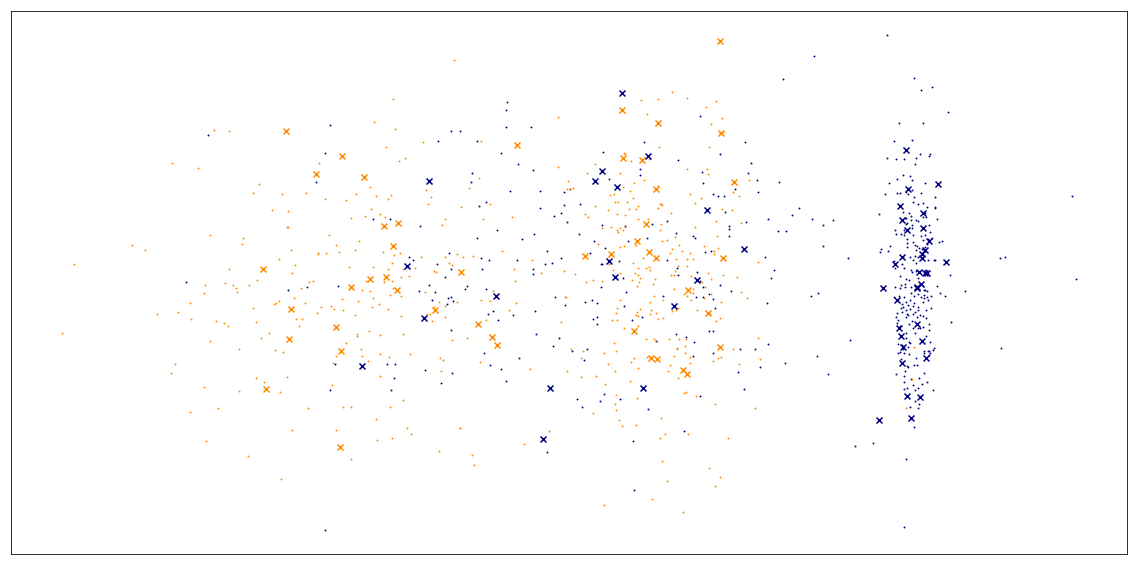

In [56]:
plt.figure(figsize=(20,10))

for n, color in enumerate(colors):
    data = xx_tr[yy_tr == n]
    plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color, label=yy_tr)

for n, color in enumerate(colors):
    data = xx_te[yy_te == n]
    plt.scatter(data[:, 0], data[:, 1], marker='x', color=color) 

plt.xticks(())
plt.yticks(())
plt.show()